Biblioteki

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
import shutil
from sklearn.model_selection import train_test_split

Ścieżki i wstępne ustawienia

In [2]:
# Ścieżka do katalogu z obrazami
edge_count_list = ['4', '5', '6', '7']
data_dir_model = 'graphs_all'
train_dir = os.path.join(data_dir_model, 'train')
validation_dir = os.path.join(data_dir_model, 'validation')

# Sprawdź, czy katalogi istnieją, jeśli nie, stwórz je
for directory in [data_dir_model, train_dir, validation_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        # Jeśli katalog nie jest pusty, wyczyść go
        for file in os.listdir(directory):
            os.remove(os.path.join(directory, file))

PermissionError: [WinError 5] Odmowa dostępu: 'graphs_all\\train'

In [7]:
# Wielkość obrazów i wielkość partii
img_height, img_width = 180, 180
batch_size = 32

In [3]:
for edge_count in edge_count_list:
    data_dir_generated = '../graph_generator/' + edge_count

    # Pobierz listę wszystkich katalogów z grafami
    all_images_catalogs = os.listdir(data_dir_generated)

    for catalog in all_images_catalogs:
        catalog_path = os.path.join(data_dir_generated, catalog)
        all_images = os.listdir(catalog_path)

        # Podziel listę obrazów na zestawy treningowe i walidacyjne
        train_images, validation_images = train_test_split(all_images, test_size=0.2, random_state=42)

        # Stwórz katalogi dla każdej klasy
        train_class_dir = os.path.join(train_dir, catalog)
        validation_class_dir = os.path.join(validation_dir, catalog)
        for directory in [train_class_dir, validation_class_dir]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # Kopiuj obrazy do odpowiednich katalogów
        for train_image in train_images:
            shutil.copy(os.path.join(catalog_path, train_image), os.path.join(train_class_dir, train_image))

        for validation_image in validation_images:
            shutil.copy(os.path.join(catalog_path, validation_image), os.path.join(validation_class_dir, validation_image))

Przenoszenie do katalogów

In [4]:
# Pobierz listę wszystkich katalogów z grafami
all_images_catalogs = os.listdir(data_dir_generated)

for catalog in all_images_catalogs:
    catalog_path = os.path.join(data_dir_generated, catalog)
    all_images = os.listdir(catalog_path)

    # Podziel listę obrazów na zestawy treningowe i walidacyjne
    train_images, validation_images = train_test_split(all_images, test_size=0.2, random_state=42)

    # Stwórz katalogi dla każdej klasy
    train_class_dir = os.path.join(train_dir, catalog)
    validation_class_dir = os.path.join(validation_dir, catalog)
    for directory in [train_class_dir, validation_class_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
        else:
            # Jeśli katalog nie jest pusty, wyczyść go
            for file in os.listdir(directory):
                os.remove(os.path.join(directory, file))

    # Kopiuj obrazy do odpowiednich katalogów
    for train_image in train_images:
        shutil.copy(os.path.join(catalog_path, train_image), os.path.join(train_class_dir, train_image))

    for validation_image in validation_images:
        shutil.copy(os.path.join(catalog_path, validation_image), os.path.join(validation_class_dir, validation_image))

In [5]:
def rgb_to_grayscale(images):
    return tf.image.rgb_to_grayscale(images)

Model

In [8]:
# Generowanie danych treningowych
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

# Generowanie danych walidacyjnych
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  validation_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = val_ds.map(lambda x, y: (rgb_to_grayscale(x), y))

# Tworzenie modelu
model = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names))
])

Found 640 files belonging to 4 classes.
Found 160 files belonging to 4 classes.


In [9]:
# Kompilacja modelu
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Trenowanie modelu
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.2946 - loss: 1.4115 - val_accuracy: 0.7875 - val_loss: 1.0426
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7937 - loss: 0.7323 - val_accuracy: 0.9312 - val_loss: 0.2178
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.9457 - loss: 0.1577 - val_accuracy: 0.9500 - val_loss: 0.1249
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9777 - loss: 0.0777 - val_accuracy: 0.9937 - val_loss: 0.0539
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9984 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9982 - loss: 0.0129 - val_accuracy: 0.8375 - val_loss: 0.3749
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.8447 - loss: 0.3782 - val_accuracy: 0.9125 - val_loss: 0.2348
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9290 - loss: 0.1462 - val_accuracy: 0.8625 - val_

In [10]:
# Wyświetlanie dokładności na zbiorze treningowym i walidacyjnym
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Dokładność na zbiorze treningowym: ", acc)
print("Dokładność na zbiorze walidacyjnym: ", val_acc)

Dokładność na zbiorze treningowym:  [0.3609375059604645, 0.8265625238418579, 0.9593750238418579, 0.973437488079071, 0.996874988079071, 0.995312511920929, 0.8578125238418579, 0.9312499761581421, 0.948437511920929, 0.9984375238418579]
Dokładność na zbiorze walidacyjnym:  [0.7875000238418579, 0.9312499761581421, 0.949999988079071, 0.9937499761581421, 1.0, 0.8374999761581421, 0.9125000238418579, 0.862500011920929, 0.9750000238418579, 0.987500011920929]


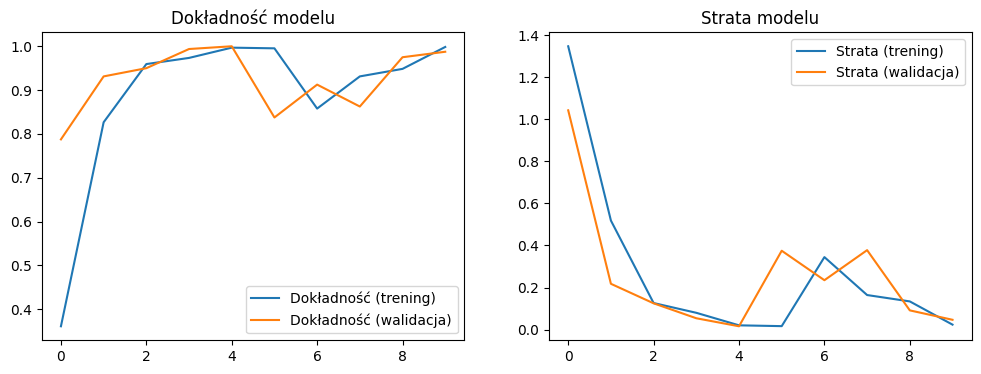

In [11]:
# Wykres dokładności
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność (trening)')
plt.plot(history.history['val_accuracy'], label='Dokładność (walidacja)')
plt.legend(loc='lower right')
plt.title('Dokładność modelu')

# Wykres straty
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata (trening)')
plt.plot(history.history['val_loss'], label='Strata (walidacja)')
plt.legend(loc='upper right')
plt.title('Strata modelu')

plt.show()

In [12]:
def get_image_filenames(folder):
    filenames = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"): # Add or modify to suit your image file types
            filenames.append(filename)
    return filenames

In [13]:
# Ścieżka do obrazu, który chcesz przetestować
test_photo_path = 'test_graphs'
test_photos = get_image_filenames(test_photo_path)

for test_photo in test_photos:
    image_path = test_photo_path + '/' + test_photo # Wybór obrazka testowego

    # Wczytanie obrazu i dostosowanie go do odpowiedniego rozmiaru
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    
    # Przekształć obraz do skali szarości
    img_array = rgb_to_grayscale(img_array)
    # Rozszerz wymiary obrazu
    img_array = tf.expand_dims(img_array, 0)

    # Przewidywanie klasy obrazu
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "|- {} -| najprawdopodobniej należy do klasy |- {} -| z prawdopodobieństwem {:.2f} procent."
        .format(test_photo, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
|- connected-drawn-1.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 98.89 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
|- cycle-45.png -| najprawdopodobniej należy do klasy |- cycle -| z prawdopodobieństwem 94.07 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- cycle-drawn-1.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 95.50 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- full-113.png -| najprawdopodobniej należy do klasy |- connected -| z prawdopodobieństwem 99.65 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- full-drawn-1.jpg -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 98.53 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- full-drawn-2.jpg -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 99.21 procent.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
|- full-drawn-3.png -| najprawdopodobniej należy do klasy |- full -| z prawdopodobieństwem 100